In [32]:
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
import tinygp
from  tinygp import kernels, GaussianProcess
from functools import partial 
import matplotlib.pyplot as plt 


In [20]:
kernel = kernels.ExpSquared(scale=1.5)

In [23]:
dx = jnp.linspace(0, 5, 100)
dx[:1]

DeviceArray([0.], dtype=float64)

In [25]:
def plot_kernel(kernel, **kwargs):
    dx = jnp.linspace(0, 5, 100)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")


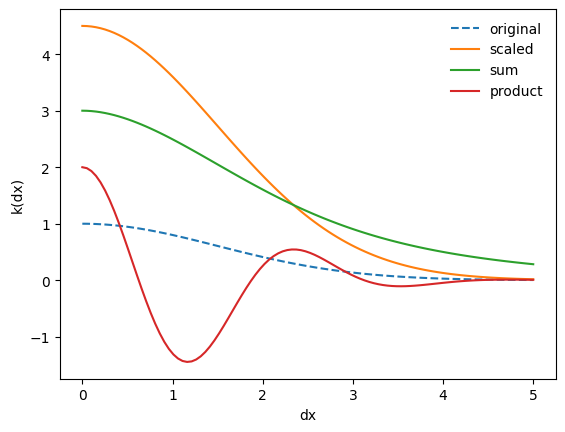

In [31]:
plot_kernel(kernel, label='original', ls='dashed')

kernel_scaled = 4.5 * kernels.ExpSquared(scale=1.5)
plot_kernel(kernel_scaled, label='scaled')

kernel_sum = kernels.ExpSquared(scale=1.5) + 2 *kernels.Matern32(scale=2.5)
plot_kernel(kernel_sum, label="sum")

kernel_prod = 2 * kernels.ExpSquared(scale=1.5) * kernels.Cosine(scale=2.5)
plot_kernel(kernel_prod, label="product")
_ = plt.legend(frameon=False)


In [39]:
X = jnp.sort(jax.random.uniform(jax.random.PRNGKey(0), minval=0., maxval=10., shape=(200,)))
gp = GaussianProcess(kernel, X)

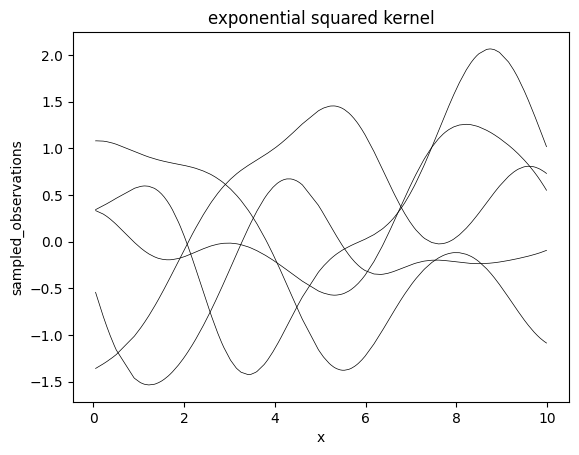

In [40]:
y = gp.sample(jax.random.PRNGKey(1), shape=(5,))
plt.plot(X, y.T, color='k', lw=.5)
plt.xlabel("x")
plt.ylabel("sampled_observations")
_ = plt.title("exponential squared kernel")

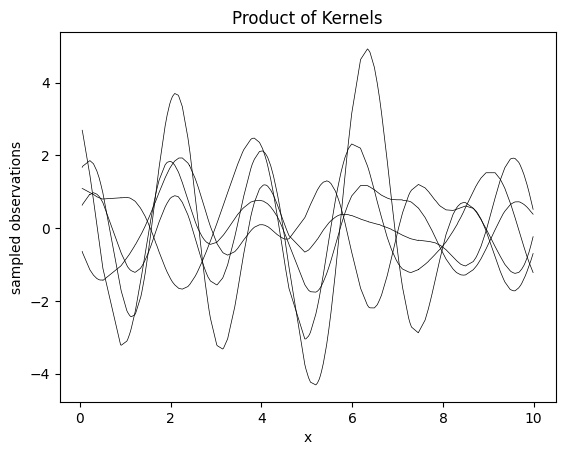

In [41]:
kernel_prod = 2 * kernels.ExpSquared(scale=1.45) * kernels.Cosine(scale=2.5)
gp = GaussianProcess(kernel_prod, X, diag=1e-5)
y = gp.sample(jax.random.PRNGKey(4), shape=(5,))

plt.plot(X, y.T, color="k", lw=0.5)
plt.xlabel("x")
plt.ylabel("sampled observations")
_ = plt.title("Product of Kernels")

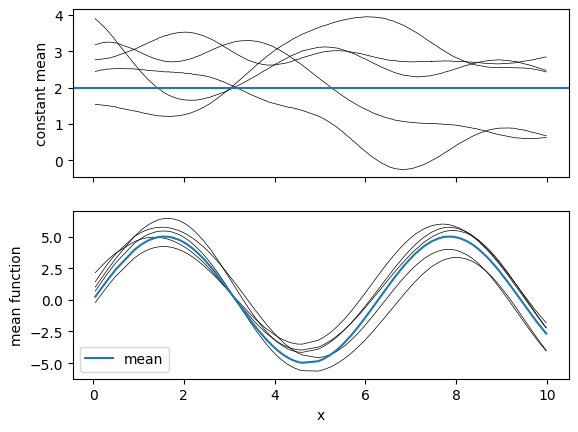

In [43]:
gp = GaussianProcess(kernel, X, diag=1e-5, mean=2.0)
y_const = gp.sample(jax.random.PRNGKey(4), shape=(5,))

def mean_function(x):
    return 5 * jnp.sin(x)

gp = GaussianProcess(kernel, X, diag=1e-5, mean=mean_function)
y_func = gp.sample(jax.random.PRNGKey(4), shape=(5,))

_, axes = plt.subplots(2, 1, sharex=True)
ax = axes[0]
ax.plot(X, y_const.T, color='k', lw=0.5)
ax.axhline(2.)
ax.set_ylabel('constant mean')

ax = axes[1]
ax.plot(X, y_func.T, color='k', lw=0.5)
ax.plot(X, jax.vmap(mean_function)(X), label='mean')
ax.legend()
ax.set_xlabel('x')
_ = ax.set_ylabel("mean function")

In [45]:
X = jnp.sort(jax.random.uniform(jax.random.PRNGKey(0), minval=0, maxval=10, shape=(10,)))
y = jnp.sin(X) + 1e-4 * jax.random.normal(jax.random.PRNGKey(1), shape=X.shape)

kernel = 0.5 * kernels.ExpSquared(scale=1.)
gp = GaussianProcess(kernel, X, diag=1e-4)
print(gp.log_probability(y))

-4.650322861701904


In [46]:
cond = gp.condition(y)
print(cond.log_probability)

-4.650322861701904


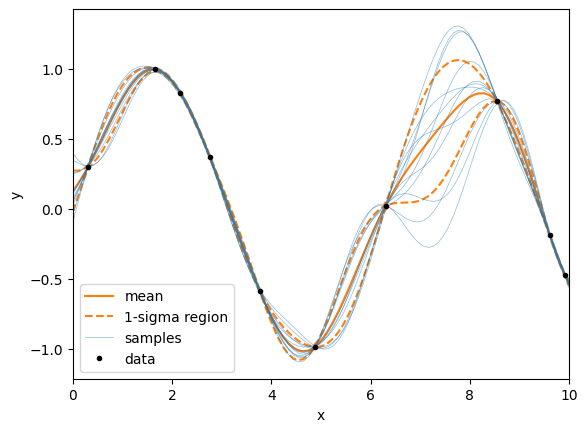

In [54]:
X_test = jnp.linspace(0, 10, 100)
_, cond_gp = gp.condition(y, X_test)

mu = cond_gp.mean 
std = jnp.sqrt(cond_gp.variance)

plt.plot(X_test, mu, "C1", label='mean')
plt.plot(X_test, mu + std, "--C1", label="1-sigma region")
plt.plot(X_test, mu - std, "--C1")

y_samp = cond_gp.sample(jax.random.PRNGKey(1), shape=(12,))
plt.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
plt.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5)
plt.plot(X, y, ".k", label="data")
plt.legend(fontsize=10)
plt.xlim(X_test.min(), X_test.max())
plt.xlabel("x")
_ = plt.ylabel("y")

In [ ]:
def build_gp(params):
    kernel = jnp.exp(params["log_amp"]) * kernels.ExpSquared(
        jnp.exp(params["log_scale"])
    )
    return GaussianProcess(kernel, X, diag=jnp.exp(params["log_diag"]))